<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Modelo_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$: Derivada do torque do robô (variação do torque com o tempo).[R_d_T]
- $\tau_{r}$: Torque do robô [R_T].
- $S_Fx$: Sensor de torque Tx [R_Fx].
- $\omega_{l}$: Velocidade da coroa [R_w_l].
- $\theta_{l}$: Ângulo da coroa [R_t_l].
- $\theta_{m}$: Ângulo do motor [R_t_m].
- $\omega_{h}$: Velocidade da pessoa [R_w_p].
- $\theta_{h}$: Ângulo da pessoa [R_t_p].
- $∫e(Interacao).dt$: Integral do erro de torque [R_i_T_e].
- $U(x)$: Sinal de controle [R_u].
- $\tau^{d}_{r}$: Torque desejado do robô [R_T_d].
- $\tau_{i}$: Torque de interação [R_T_i].
- $\frac{d\omega_{l}}{dt}$: Derivada da velocidade da coroa  (variação da velocidade da coroa com o tempo). [R_d_w_l]
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$: Ângulo do motor na perna esquerda .[L_t_m]
- $\theta_{l, L}$: Ângulo da coroa na perna esquerda .[L_t_l]
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$: Torque real no lado esquerdo .[L_T_r]
- $\tau^{d}_{r, L}$: Torque desejado no lado esquerdo . [L_T_d]

# Bibliotecas

In [1]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [3]:
drive.mount('/content/drive')
t1_markov = "drive/MyDrive/Markov/last_data_MarkovMao 1.dat"
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx', 'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m', 'R_d_w_l', 'phase', 'L_t_m',
               'L_t_l', 'L_u', 'L_T_r', 'L_T_d']
pd.set_option('display.float_format', lambda x: '%.10f' % x)
markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = markov_t1.iloc[1870:11760]

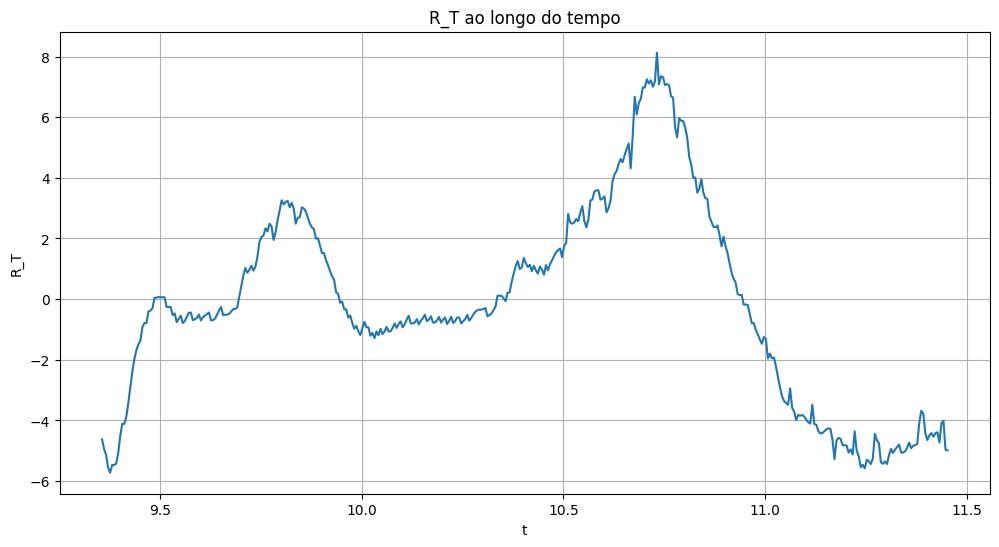

In [5]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(data['t'].iloc[:420], data['R_T'].iloc[:420])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

# 2º Passo: Cálculo do torque de interação τ_i

In [6]:
Ka = 200  # Rigidez do acessório
Ba = 10   # Amortecimento do acessório
data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
data['d_tau_i'] = np.gradient(data['tau_i'])

<ipython-input-6-ada45a1a3584>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tau_i'] = Ka * (data['R_t_p'] - data['R_t_l']) + Ba * (data['R_w_p'] - data['R_w_l'])
<ipython-input-6-ada45a1a3584>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['d_tau_i'] = np.gradient(data['tau_i'])


# 3º Passo: Separação e Normalização dos dados


In [7]:
dataset = data.copy()
X = dataset[['tau_i', 'd_tau_i', 'phase', 'R_T']]
y = dataset[['R_T']]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 4º Passo: Criar sequências de dados para LSTM

In [8]:
timesteps = 420  # Ajustar conforme a análise
n_features = X_scaled.shape[1]

def create_sequences(X, y, timesteps):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:i+timesteps])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(X_scaled, y_scaled, timesteps)
print("Forma dos dados de entrada para LSTM:", X_train.shape)
print("Forma dos dados de saída:", y_train.shape)

Forma dos dados de entrada para LSTM: (9470, 420, 4)
Forma dos dados de saída: (9470, 1)


# 5º Passo: Definição do Modelo LSTM otimizado

In [9]:
model_cnn_lstm = Sequential()

# Ajustar o input_shape para refletir o número de características (4)
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features), padding='causal'))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))

# Camada LSTM com return_sequences para empilhar
model_cnn_lstm.add(LSTM(128, return_sequences=True))
model_cnn_lstm.add(Dropout(0.2))

# Camada LSTM final
model_cnn_lstm.add(LSTM(64, return_sequences=False))
model_cnn_lstm.add(Dropout(0.2))

# Camada de saída (regressão - sem ativação)
model_cnn_lstm.add(Dense(1))

# Compilação para regressão (usando Huber ou MSE)
model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=Huber(),  # Alternativa: 'mse'
    metrics=['MAE', 'MSE']
)

model_cnn_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 420, 64)        │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 210, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 210, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 210, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 149,121 (582.50 KB)

 Trainable params: 149,121 (582.50 KB)

 Non-trainable params: 0 (0.00 B)

# 6º Passo: Treinamento do Modelo

In [10]:
# Treinamento do modelo
history = model_cnn_lstm.fit(
    X_train, y_train,
    epochs=32,            # Número de épocas ajustável
    batch_size=32,        # Lote para atualização dos pesos
    validation_split=0.4, # Separação para validação
    verbose=1             # Exibição detalhada do progresso
)

Epoch 1/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 109s 585ms/step - MAE: 0.1029 - MSE: 0.0245 - loss: 0.0123 - val_MAE: 0.0281 - val_MSE: 0.0014 - val_loss: 6.7602e-04
Epoch 2/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 110s 620ms/step - MAE: 0.0437 - MSE: 0.0033 - loss: 0.0016 - val_MAE: 0.0295 - val_MSE: 0.0014 - val_loss: 6.9548e-04
Epoch 3/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 136s 587ms/step - MAE: 0.0395 - MSE: 0.0026 - loss: 0.0013 - val_MAE: 0.0234 - val_MSE: 8.7372e-04 - val_loss: 4.3686e-04
Epoch 4/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 144s 599ms/step - MAE: 0.0371 - MSE: 0.0023 - loss: 0.0011 - val_MAE: 0.0201 - val_MSE: 6.9489e-04 - val_loss: 3.4745e-04
Epoch 5/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 141s 589ms/step - MAE: 0.0360 - MSE: 0.0022 - loss: 0.0011 - val_MAE: 0.0184 - val_MSE: 5.9526e-04 - val_loss: 2.9763e-04
Epoch 6/32
178/178 ━━━━━━━━━━━━━━━━━━━━ 147s 622ms/step - MAE: 0.0337 - MSE: 0.0018 - loss: 9.2344e-04 - val_MAE: 0.0260 - val_MSE: 0.0010 - val_loss: 5.2260e-04
Epoch 7/32
178/178 ━━━━━━━━━━━━━━━━━

# 7º Passo: Avaliação e Previsão

In [ ]:
y_pred_scaled = model_cnn_lstm.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_train_rescaled = scaler_y.inverse_transform(y_train)

# Métricas adicionais
r2 = r2_score(y_train_rescaled, y_pred)
mae = mean_absolute_error(y_train_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_train_rescaled, y_pred))

print(f'R²: {r2}')
print(f'MAE: {mae:.4f} Nm')
print(f'RMSE: {rmse:.4f} Nm')

296/296 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step
R²: 0.9899382036854603
MAE: 0.2275 Nm
RMSE: 0.3024 Nm


# 8º Passo: Visualização das perdas (train vs validation)

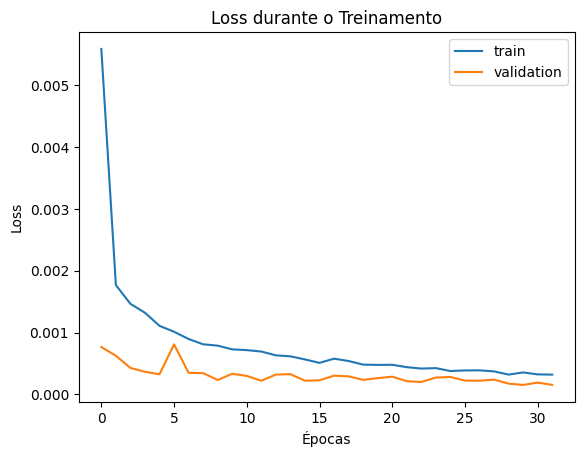

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.show()

# 9º Passo: Gráfico comparativo entre valores reais e previsões

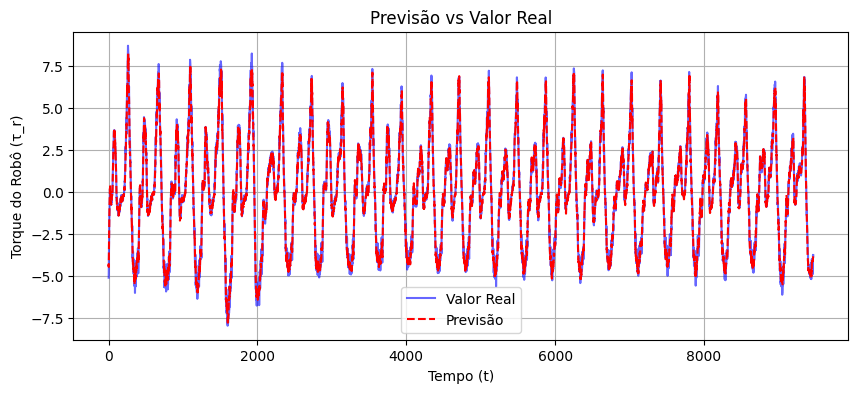

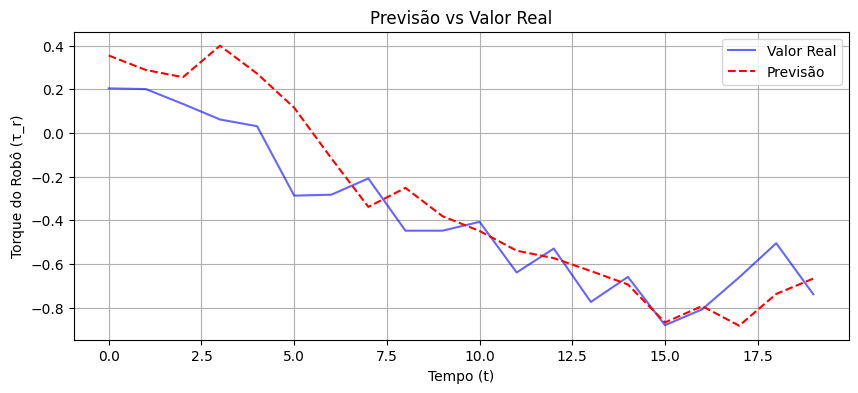

In [ ]:
def plot_predictions(y_true, y_pred, title='Previsão vs Valor Real'):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true.flatten(), label='Valor Real', color='blue', alpha=0.6)
    plt.plot(y_pred.flatten(), label='Previsão', color='red', linestyle='--', alpha=1)
    plt.title(title)
    plt.xlabel('Tempo (t)')
    plt.ylabel('Torque do Robô (τ_r)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exibir previsões vs valores reais para uma parte do dataset
plot_predictions(y_train_rescaled[:], y_pred[:])
plot_predictions(y_train_rescaled[420:440], y_pred[420:440])



# 10º Passo: Erro

In [ ]:
# Calcular o erro como a diferença entre os valores reais e preditos
erro = y_train_rescaled.flatten() - y_pred.flatten()

#11º Passo: Plot do Erro

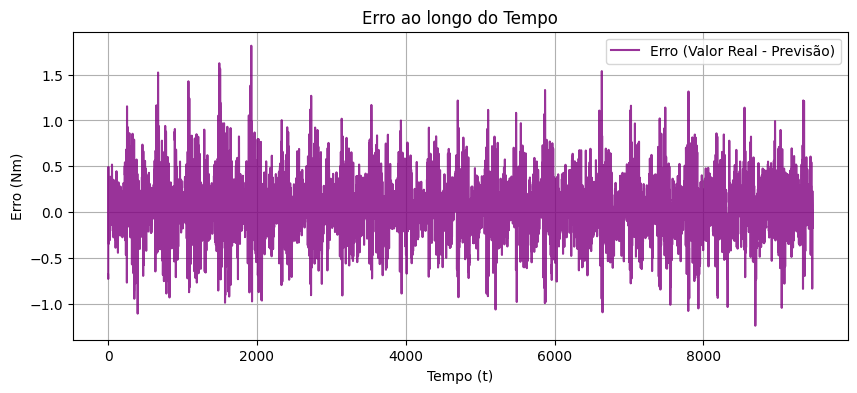

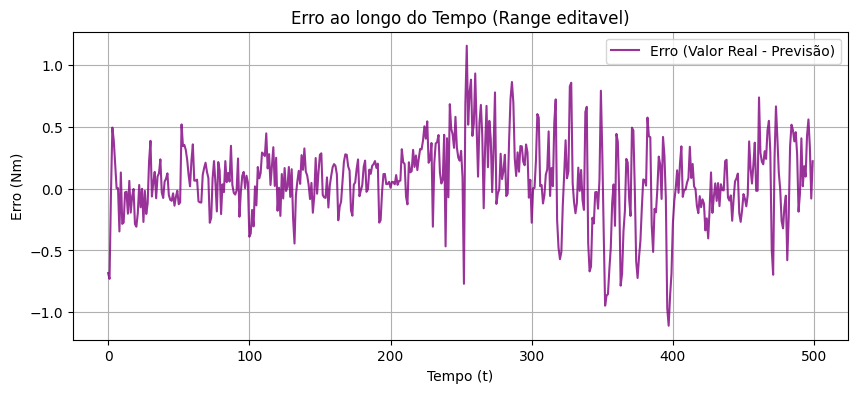

Média do Erro: 0.0534 Nm
Desvio Padrão do Erro: 0.2976 Nm


In [ ]:
# Plotar o erro no tempo
plt.figure(figsize=(10, 4))
plt.plot(erro[:], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Exibir o erro apenas para uma janela de tempo específica (por exemplo, primeiros 3000 pontos)
plt.figure(figsize=(10, 4))
plt.plot(erro[:500], label='Erro (Valor Real - Previsão)', color='purple', alpha=0.8)
plt.title('Erro ao longo do Tempo (Range editavel)')
plt.xlabel('Tempo (t)')
plt.ylabel('Erro (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# Estatísticas do erro
mean_error = np.mean(erro)
std_error = np.std(erro)
print(f'Média do Erro: {mean_error:.4f} Nm')
print(f'Desvio Padrão do Erro: {std_error:.4f} Nm')

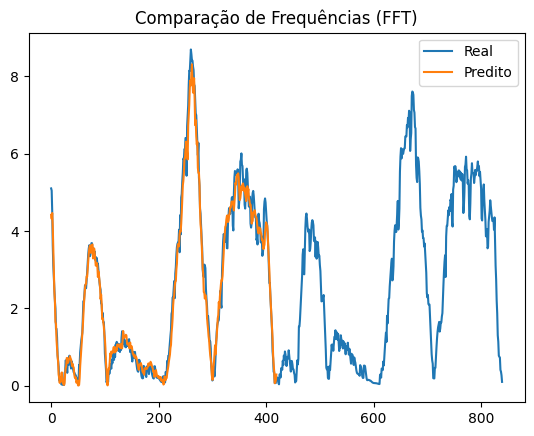

In [ ]:
from scipy.fft import fft

fft_real = np.abs(fft(y_train_rescaled[:840]))
fft_pred = np.abs(fft(y_pred[:420]))

plt.plot(fft_real, label='Real')
plt.plot(fft_pred, label='Predito')
plt.title('Comparação de Frequências (FFT)')
plt.legend()
plt.show()

#12º Passo: Validação

In [ ]:
# Processo reverso para verificar τ_i = 0

# Vamos criar um dataframe com as previsões e valores reais
results = pd.DataFrame({
    'Real_R_T': y_train_rescaled.flatten(),
    'Predicted_R_T': y_pred.flatten(),
    'Time': data['t'].iloc[timesteps:len(y_train_rescaled)+timesteps].values
})

# Adicionar as colunas relevantes ao dataframe de resultados
results['R_w_p'] = data['R_w_p'].iloc[timesteps:len(y_train_rescaled)+timesteps].values
results['R_w_l'] = data['R_w_l'].iloc[timesteps:len(y_train_rescaled)+timesteps].values
results['R_t_p'] = data['R_t_p'].iloc[timesteps:len(y_train_rescaled)+timesteps].values
results['R_t_l'] = data['R_t_l'].iloc[timesteps:len(y_train_rescaled)+timesteps].values

# Calcular o torque de interação a partir das previsões
# Assumindo que quando o modelo prevê R_T corretamente, podemos inferir τ_i
# Podemos rearranjar a equação original para isolar τ_i

# Para verificar τ_i = 0, precisamos que:
# Ka * (R_t_p - R_t_l) + Ba * (R_w_p - R_w_l) = 0
# Ou seja:
# (R_t_p - R_t_l) = -(Ba/Ka) * (R_w_p - R_w_l)

# Vamos calcular a diferença esperada se τ_i = 0
results['expected_t_diff'] = -(Ba/Ka) * (results['R_w_p'] - results['R_w_l'])
results['actual_t_diff'] = results['R_t_p'] - results['R_t_l']

# Criar uma coluna que indica quando o torque de interação é aproximadamente zero
tolerance = 0.01  # Tolerância para considerar zero
results['tau_i_zero'] = np.abs(results['actual_t_diff'] - results['expected_t_diff']) < tolerance

# Calcular a porcentagem do tempo em que τ_i ≈ 0
zero_percentage = results['tau_i_zero'].mean() * 100
print(f"O torque de interação τ_i é aproximadamente zero em {zero_percentage:.2f}% do tempo")

#13º Passo: Torque de Interação Real vs Torque de Interação Modelo

In [ ]:
# Visualizar os momentos em que τ_i ≈ 0
plt.figure(figsize=(12, 6))
plt.plot(results['Time'], results['actual_t_diff'], label='Diferença real de torque (R_t_p - R_t_l)')
plt.plot(results['Time'], results['expected_t_diff'],
         label='Diferença esperada para τ_i=0', linestyle='--')
plt.scatter(results[results['tau_i_zero']]['Time'],
            results[results['tau_i_zero']]['actual_t_diff'],
            color='green', label='τ_i ≈ 0')
plt.title('Verificação de Torque de Interação Zero')
plt.xlabel('Tempo (t)')
plt.ylabel('Diferença de Torque')
plt.legend()
plt.grid(True)
plt.show()

# Análise adicional: Verificar a relação entre R_T previsto e τ_i zero
plt.figure(figsize=(12, 6))
plt.plot(results['Time'], results['Real_R_T'], label='R_T Real')
plt.plot(results['Time'], results['Predicted_R_T'], label='R_T Previsto', linestyle='--')
plt.scatter(results[results['tau_i_zero']]['Time'],
            results[results['tau_i_zero']]['Real_R_T'],
            color='green', label='τ_i ≈ 0')
plt.title('Relação entre R_T e τ_i zero')
plt.xlabel('Tempo (t)')
plt.ylabel('R_T')
plt.legend()
plt.grid(True)
plt.show()